In [1]:
# Import lib
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from dask.distributed import Client
import warnings
import time
import glob
import seaborn as sns
import dask
import geopandas as gpd
import rasterio.mask
from shapely.geometry import mapping
import rioxarray
from rasterio import features
from affine import Affine
from pyhdf.SD import SD, SDC

warnings.filterwarnings("ignore")

In [ ]:
# Function to plot dataset
# Function to plot sample data
def plot_sample_grid(ds,time_idx,ax):
    
    p = ds.AOD.isel(time=time_idx).plot.pcolormesh(x='lon', y='lat', ax=ax,cmap='jet_r',alpha=0.8)
    for i in range(len(ds.lat.data)):
        for j in range(len(ds.lon.data)):
            ax.annotate(str(round(float(ds.AOD.isel(time=time_idx,lat=i,lon=j).values),2)), 
                         xy=(ds.lon[j], ds.lat[i]), 
                         color='black', ha='center', va='center')
    ax.set_xticks(ds.lon.data)
    ax.set_yticks(ds.lat.data)
    #ax.set_title('Sample Dataset(0.1)')
    
def plot_group_grid(ds,time_idx,ax):
    p = ds.AOD.isel(time=time_idx).plot.pcolormesh(x='lon', y='lat', ax=ax,cmap = 'jet_r',alpha=0.8)
    for i in range(len(ds.lat.data)):
        for j in range(len(ds.lon.data)):
            ax.annotate(str(round(float(ds.AOD.isel(time=time_idx,lat=i,lon=j).values),2)), 
                         xy=(ds.lon[j], ds.lat[i]), 
                         color='black', ha='center', va='center')
    ax.set_xticks(ds.lon.data)
    ax.set_yticks(ds.lat.data)
    ax.set_title('Grouping grid cell(0.25)')

In [ ]:
# Sample test
res = 0.1 # input resolution
start_lat = 8
end_lat = 9

start_lon = 68
end_lon = 69

#time = pd.date_range('2018-01-01T11:00:00',periods=4,freq='12h')

time = pd.date_range('2018-01-01', periods=1, freq='1h').union(pd.date_range('2018-01-02', periods=2, freq='1h')).union(pd.date_range('2018-01-3', periods=1, freq='1h'))

lat = np.arange(start_lat,end_lat+res,res) 
lon = np.arange(start_lon,end_lon+res,res)

t = len(time)
m = len(lat)
n = len(lon)


data = np.round(np.random.rand(t,m,n),1)

#  Randomly assign NaN value to data
for i in range(np.random.randint(0,m*n*t)):
    data[np.random.randint(0,t),np.random.randint(0,m),np.random.randint(0,n)] = np.nan


data_set = xr.Dataset({"AOD": (["time","lat","lon"],data)},
                 coords={"time":time,"lat": lat,"lon":lon})

print(f'Sample Data created : {data_set.dims}')

In [ ]:
out_res = 0.25

out_res = 0.25
minx = data_set.lon.min().item()
maxx = data_set.lon.max().item()
miny = data_set.lat.min().item()
maxy = data_set.lat.max().item()

# set up new lat/lon grid
# new_grid_x = np.arange(minx,maxx+out_res,out_res)
# new_grid_y = np.arange(miny,maxy+out_res,out_res)

# New lat,lon value with offset of interval_window

interval_window = out_res/2
new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label


print(new_grid_x,new_grid_y)
gb1 = data_set.groupby_bins("lon", bins=new_grid_x).apply(
    lambda x: x.groupby_bins("lat",bins=new_grid_y).apply(
        lambda y:  y.groupby('time').mean(dim=['lat', 'lon']).where((
                        y.groupby('time').count(dim=['lat', 'lon'])/(y.groupby('time').count(dim=['lat', 'lon']) + y.groupby('time').apply(
                        lambda z: z.isnull().sum(dim=['lat', 'lon'])))
                    ) >= 0.5,np.nan) 
        )
    )

gb1 = gb1.rename({"lon_bins":"lon","lat_bins":"lat"})
gb1['lat'] = new_grid_y[:-1] + interval_window
gb1['lon'] = new_grid_x[:-1] + + interval_window

# Change lat and lon value to 0.25
# gb1['lat_bins'] = new_lat[:-1] + interval_window
# gb1['lon_bins'] = new_lon[:-1] + interval_window


print(f"Grouping 0.1 x 0.1 cell into {out_res} x {out_res} Done")

In [ ]:
# minx = data_set.lon.min().item()
# maxx = data_set.lon.max().item()
# miny = data_set.lat.min().item()
# maxy = data_set.lat.max().item()

# out_res = 0.25

# # set up new lat/lon grid
# new_grid_x = np.arange(
#     np.ceil(minx / out_res) * out_res,
#     (np.floor(maxx / out_res) + out_res*2) * out_res + out_res,
#     out_res
# )
# new_grid_y = np.arange(
#     np.ceil(miny / out_res) * out_res,
#     (np.floor(maxy / out_res) + out_res*2) * out_res + out_res,
#     out_res
# )
# print(new_grid_x,new_grid_y)

# gb2 = data_set.interp(lon=new_grid_x, lat=new_grid_y, method="nearest")
# print(gb2)


In [ ]:
#PLOTTING
fig,ax = plt.subplots(2,2,figsize=(15,10))

plot_group_grid(gb1,0,ax[0][0])
plot_group_grid(gb1,1,ax[0][1])
plot_group_grid(gb1,2,ax[1][0])
plot_group_grid(gb1,3,ax[1][1])

plt.suptitle("Regrid DATASET >=0.5 using custom func")
plt.show()

In [ ]:
#PLOTTING
fig,ax = plt.subplots(2,2,figsize=(15,10))

plot_group_grid(gb2,0,ax[0][0])
plot_group_grid(gb2,1,ax[0][1])
plot_group_grid(gb2,2,ax[1][0])
plot_group_grid(gb2,3,ax[1][1])

plt.suptitle("Regrid DATASET using interp func")
plt.show()

In [ ]:
fig,ax = plt.subplots(2,2,figsize=(15,10))

plot_sample_grid(data_set,0,ax[0][0])
plot_sample_grid(data_set,1,ax[0][1])
plot_sample_grid(data_set,2,ax[1][0])
plot_sample_grid(data_set,3,ax[1][1])

plt.suptitle("SAMPLE DATASET WITH 3 days data")
plt.show()

# loading,slicing,shaping,filtering and regridding

In [2]:
# TESTING ON ACTUAL DATA
#Loading AOD Dataset for testing 
aod_file = glob.glob('./Data/AOD/*')
aod_insat3D = glob.glob(aod_file[0]+'/*')
aod_insat3DR = glob.glob(aod_file[1]+'/*')
ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

#slicing
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99)).load()

#merging
ds_merged = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')

In [3]:
aod_modis_dir = glob.glob(aod_file[3]+'/*')
# MODIS DIR contain sub folder with no time dimension
# Create empty list to store file path with time stamp
aod_modis_path = []
time_stamp = []

# Mention Starting Year
start_year = np.datetime64('2018')

for path in aod_modis_dir:
    
    aod_modis_path.append(glob.glob(path+'/*'))
    day_no  = int(path.split('\\')[-1]) # Day number according to file name i,e 001,002,003,...365
    time_stamp.append(start_year + np.timedelta64(day_no-1, 'D')) # add timestamp to that particular file index

aod_modis_path[:5],time_stamp[:5]

([['./Data/AOD\\MODIS_2018\\001\\MOD08_D3.A2018001.061.2018003215357.hdf'],
  ['./Data/AOD\\MODIS_2018\\002\\MOD08_D3.A2018002.061.2018003215942.hdf'],
  ['./Data/AOD\\MODIS_2018\\003\\MOD08_D3.A2018003.061.2018004083950.hdf'],
  ['./Data/AOD\\MODIS_2018\\004\\MOD08_D3.A2018004.061.2018005083354.hdf'],
  ['./Data/AOD\\MODIS_2018\\005\\MOD08_D3.A2018005.061.2018008181118.hdf']],
 [numpy.datetime64('2018-01-01'),
  numpy.datetime64('2018-01-02'),
  numpy.datetime64('2018-01-03'),
  numpy.datetime64('2018-01-04'),
  numpy.datetime64('2018-01-05')])

In [4]:
# Declare Datafield Name
DATAFIELD_NAME = 'AOD_550_Dark_Target_Deep_Blue_Combined_Mean'

# Temporary list to store data to make xarray dataset
DATA = []
TIME = []
LAT = []
LON = []

# Read MODIS file
for idx, FILE_NAME in  enumerate(aod_modis_path):
        
    hdf = SD(*FILE_NAME, SDC.READ)
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)
    
    # Read dataset.
    data_raw = hdf.select(DATAFIELD_NAME)
    data = data_raw[:,:].astype(np.double)

    # Read lat/lon.
    xdim = hdf.select('XDim')
    lon = xdim[:].astype(np.double)

    ydim = hdf.select('YDim')
    lat = ydim[:].astype(np.double)
    
    # Retrieve attributes.
    attrs = data_raw.attributes(full=1)
    lna=attrs["long_name"]
    long_name = lna[0]
    aoa=attrs["add_offset"]
    add_offset = aoa[0]
    fva=attrs["_FillValue"]
    _FillValue = fva[0]
    sfa=attrs["scale_factor"]
    scale_factor = sfa[0]        
    ua=attrs["units"]
    units = ua[0]

    # Fill 9999 with NaN value
    data[data == _FillValue] = np.nan
    data =  scale_factor * (data - add_offset) 
    datam = np.ma.masked_array(data, np.isnan(data))
    
    # Store result in DATA and TIME list
    TIME.append(time_stamp[idx])
    DATA.append(data)
    

# Make np array for list
TIME = np.array(TIME)
LAT = np.array(lat)
LON = np.array(lon)
DATA = np.array(DATA)

print("Data file is ready !!!")

Data file is ready !!!


In [5]:
# Create Modis Dataset
ds_modis = xr.Dataset(
        {
            'AOD': (['time','latitude', 'longitude'], DATA),
            'time': (['time'],TIME),
            'latitude': (['latitude'], LAT),
            'longitude': (['longitude'], LON),
        }
    )


ds_modis = ds_modis.sel(latitude=slice(39,8),longitude=slice(67,98))

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left

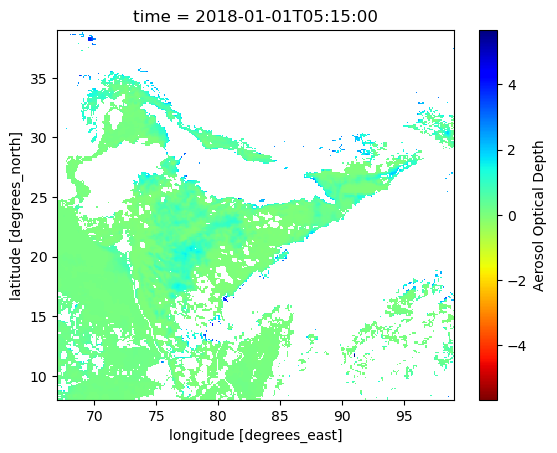

In [6]:
print(ds_merged)
ds_merged.AOD.isel(time=0).plot(cmap='jet_r')

In [7]:
# Shaping dataset
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))

def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [8]:
sf_dir = './Data/India_Boundary/India_Boundary.shp'

ds_mask = add_shape_coord_from_data_array(ds_merged, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_merged_shaped = ds_mask.drop_vars('MASK')

ds_mask = add_shape_coord_from_data_array(ds_modis, sf_dir, "MASK")
ds_mask = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds_modis_shaped = ds_mask.drop_vars('MASK')

<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01T05:15:00 ... 2018-12-31T08:30:00
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left

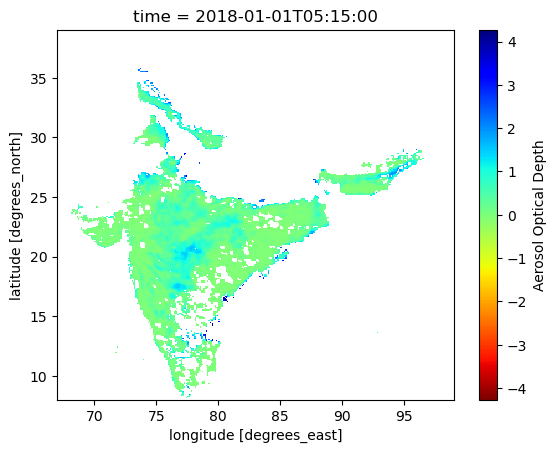

In [9]:
print(ds_merged_shaped)
ds_merged_shaped.AOD.isel(time=0).plot(cmap='jet_r')

In [12]:

# 2-sigma rule filter
def twoSig_pos_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean + 1*std
    return res.where(count>=6)

def twoSig_neg_rule(group):
    
    count = group.count(dim='time')
    mean  = group.mean(dim='time')
    std = group.std(dim = 'time')
    
    res = mean - 1*std
    return res.where(count>=6)

def twoSigfilter(ds):
   
    # Converting hourly to daily timestamp
    daily_timestamp = ds.time.dt.floor('1D')
    unique_day = np.unique(daily_timestamp)
    
    # COUNT PLOT ON TIME DIMENSION
    ds_day_count = ds.groupby(daily_timestamp).count(dim='time').rename({'floor':'time'})

    # Calculating mean + 2*sigma
    ds_twoSig_pos= ds.groupby(daily_timestamp).apply(twoSig_pos_rule).rename({'floor': 'time'})

    # Calculating mean - 2*sigma
    ds_twoSig_neg= ds.groupby(daily_timestamp).apply(twoSig_neg_rule).rename({'floor': 'time'})

    # re-arrange coordinates
    ds_twoSig_pos = ds_twoSig_pos[['time','latitude','longitude','AOD']]
    ds_twoSig_neg = ds_twoSig_neg[['time','latitude','longitude','AOD']]

    # Assigning Time Coordinate value as data_set timestamp since it is 0,1,..365 format
    
    print(len(ds_day_count.time.values))
    ds_twoSig_pos.coords['time'] = unique_day
    ds_twoSig_neg.coords['time'] = unique_day
    
    # Flooring hourly time to day time and generate duplicate time index for same hour
    ds.coords['time'] = ds.time.dt.floor('1D')

    # Create a mask for filtering out the data
    mask = (ds['AOD'] < ds_twoSig_pos.sel(time=ds['time'])) & (ds['AOD'] > ds_twoSig_neg.sel(time=ds['time']))

    # Apply the mask to filter out the data
    filtered_data = ds.where(mask)
    
    return filtered_data

In [13]:
ds_merged_filter = twoSigfilter(ds_merged_shaped)

365


<xarray.Dataset>
Dimensions:    (time: 4475, latitude: 310, longitude: 320)
Coordinates:
  * latitude   (latitude) float64 38.95 38.85 38.75 38.65 ... 8.25 8.15 8.05
  * longitude  (longitude) float64 67.05 67.15 67.25 67.35 ... 98.75 98.85 98.95
  * time       (time) datetime64[ns] 2018-01-01 2018-01-01 ... 2018-12-31
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longit

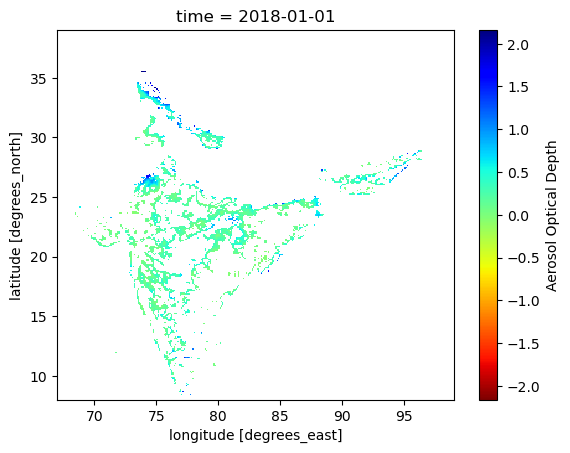

In [14]:
print(ds_merged_filter)
ds_merged_filter.AOD.isel(time=0).plot(cmap='jet_r')

In [15]:
# DAILY MEAN
ds_merged_daily  = ds_merged_filter.resample(time='1D').mean()
ds_modis_daily = ds_modis_shaped.resample(time='1D').mean()


In [33]:
# regridding 
def regrid_1(ds):
    minx = ds_modis_daily.longitude.min().item()
    maxx = ds_modis_daily.longitude.max().item()
    miny = ds_modis_daily.latitude.min().item()
    maxy = ds_modis_daily.latitude.max().item()


    out_res = 1
    interval_window = out_res/2
    # set up new lat/lon grid
    new_grid_x = np.arange(
        np.ceil(minx / out_res) * out_res,
        (np.floor(maxx / out_res) + 0.5) * out_res,
        out_res
    )
    new_grid_y = np.arange(
        np.ceil(miny / out_res) * out_res,
        (np.floor(maxy / out_res) + 0.5) * out_res,
        out_res
    )
    
    
    return ds.interp(longitude=new_grid_x[:] + interval_window, latitude=new_grid_y[:] + interval_window, method="nearest")

def regrid_2(ds,thres,res):

    out_res = res
    minx = ds_modis_daily.longitude.min().item()
    maxx = ds_modis_daily.longitude.max().item()
    miny = ds_modis_daily.latitude.min().item()
    maxy = ds_modis_daily.latitude.max().item()

    lat = 'latitude'
    lon = 'longitude'
    
    interval_window = out_res/2
    new_grid_y = np.arange(miny-interval_window, maxy+out_res, out_res) # Latitude label
    new_grid_x = np.arange(minx-interval_window, maxx+out_res, out_res) # longitude Label

    #print(new_grid_x,new_grid_y)
    gb1 = ds.groupby_bins(lon, bins=new_grid_x).apply(
        lambda x: x.groupby_bins(lat,bins=new_grid_y).apply(
            lambda y:  y.groupby('time').mean(dim=[lat,lon]).where((
                            y.groupby('time').count(dim=[lat, lon])/(y.groupby('time').count(dim=[lat, lon]) + y.groupby('time').apply(
                            lambda z: z.isnull().sum(dim=[lat, lon])))
                        ) >= thres,np.nan) 
            )
        )

    gb = gb1.rename({lon+"_bins":lon,lat+"_bins":lat})
    gb[lat] = new_grid_y[:-1] + interval_window
    gb[lon] = new_grid_x[:-1] + interval_window
    
    return gb


In [34]:
ds_merged_coarse_1  = regrid_1(ds_merged_daily)
ds_merged_coarse_1

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 30, longitude: 30)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * longitude  (longitude) float64 68.5 69.5 70.5 71.5 ... 94.5 95.5 96.5 97.5
  * latitude   (latitude) float64 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
Data variables:
    AOD        (time, latitude, longitude) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [35]:
ds_merged_coarse_2  = regrid_2(ds_merged_daily,0.1,1)
ds_merged_coarse_2

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.5 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [36]:
ds_merged_coarse_3  = regrid_2(ds_merged_daily,0.2,1)
ds_merged_coarse_3

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 31, longitude: 31)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.5 9.5 10.5 11.5 12.5 ... 35.5 36.5 37.5 38.5
  * longitude  (longitude) float64 67.5 68.5 69.5 70.5 ... 94.5 95.5 96.5 97.5
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

In [37]:
ds_merged_coarse_4  = regrid_2(ds_merged_daily,0.5,0.75)
ds_merged_coarse_4

<xarray.Dataset>
Dimensions:    (time: 365, latitude: 41, longitude: 41)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * latitude   (latitude) float64 8.5 9.25 10.0 10.75 ... 36.25 37.0 37.75 38.5
  * longitude  (longitude) float64 67.5 68.25 69.0 69.75 ... 96.0 96.75 97.5
Data variables:
    AOD        (longitude, latitude, time) float32 nan nan nan ... nan nan nan
Attributes: (12/28)
    conventions:                                                    CF-1.6
    title:                                                          3RIMG_11O...
    institute:                                                      BES,SAC/I...
    source:                                                         IMAGER (IMG)
    Unique_Id:                                                      3RIMG_11O...
    Satellite_Name:                                                 INSAT-3DR
    ...                                                             ...
    left_longitude:                                                 45.05
    right_longitude:                                                100.05
    upper_latitude:                                                 45.05
    lower_latitude:                                                 -9.95
    lat_interval:                                                   0.1
    lon_interval:                                                   0.1

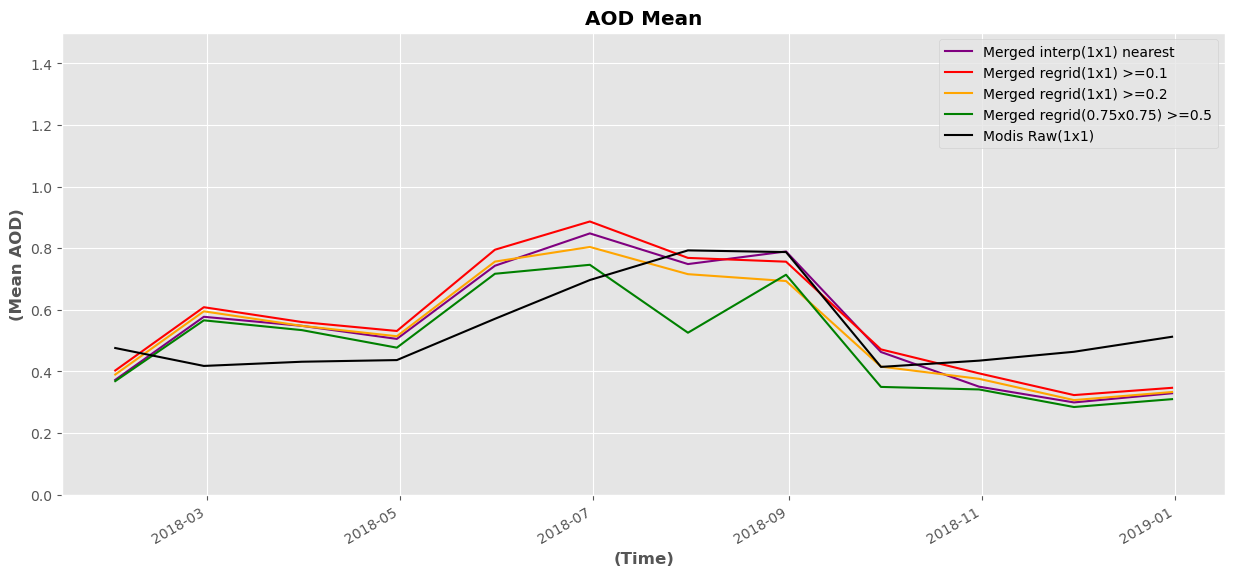

In [41]:
fig, ax = plt.subplots(figsize=(15,6) )
    
data1_mean = ds_merged_coarse_1['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data2_mean = ds_merged_coarse_2['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data3_mean = ds_merged_coarse_3['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data4_mean = ds_merged_coarse_4['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))
data5_mean = ds_modis_daily['AOD'].resample(time = '1M').mean().mean(dim=('latitude', 'longitude'))

colors = ['purple', 'red', 'orange', 'green', 'black', 'blue', 'yellow']
colors = colors[:5]

# Set the line colors for each plot using the colors list
for i, (data, label) in enumerate(zip([data1_mean, data2_mean, data3_mean, 
                                       data4_mean, data5_mean],
                                      ['Merged interp(1x1) nearest', 'Merged regrid(1x1) >=0.1',
                                       'Merged regrid(1x1) >=0.2', 'Merged regrid(0.75x0.75) >=0.5',
                                       'Modis Raw(1x1)'])):
    data.plot.line(ax=ax, label=label, color=colors[i])


ax.legend()
ax.set_xlabel('(Time)',weight='bold')
ax.set_ylabel('(Mean AOD)',weight='bold')
ax.set_title(f'AOD Mean',weight='bold')

ax.set_ylim(0,1.5)
plt.style.use('ggplot')

#plt.savefig('./plots/aod_plot/Insat_vs_Modis/Different_regrid_0.75&0.1_method.png')
plt.show()